3000


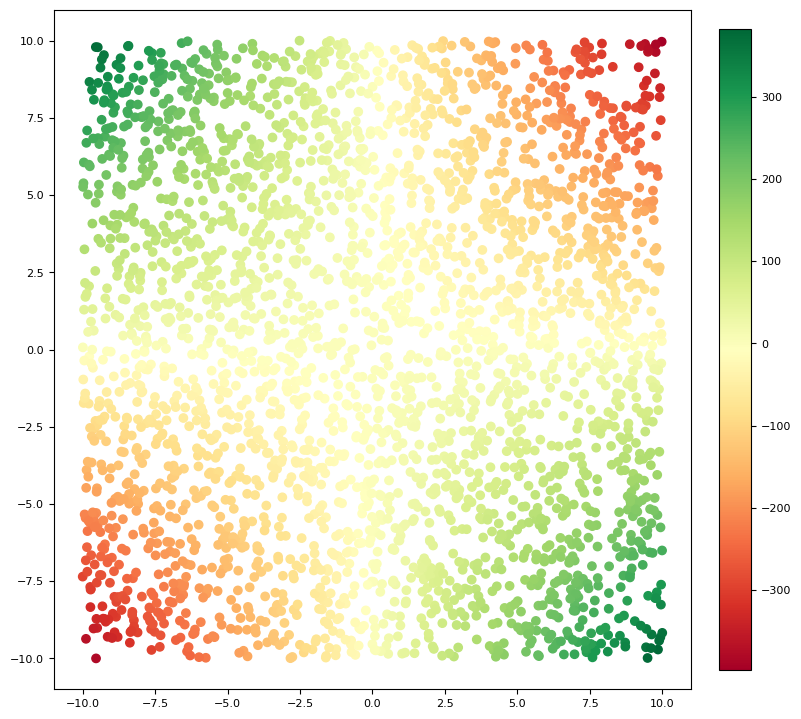

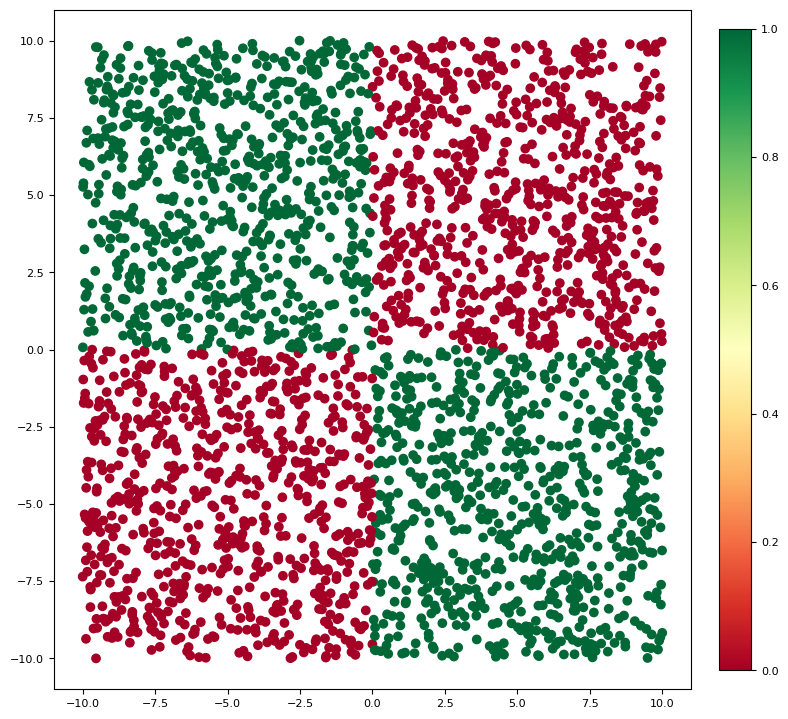

(20, 20) (20, 20)


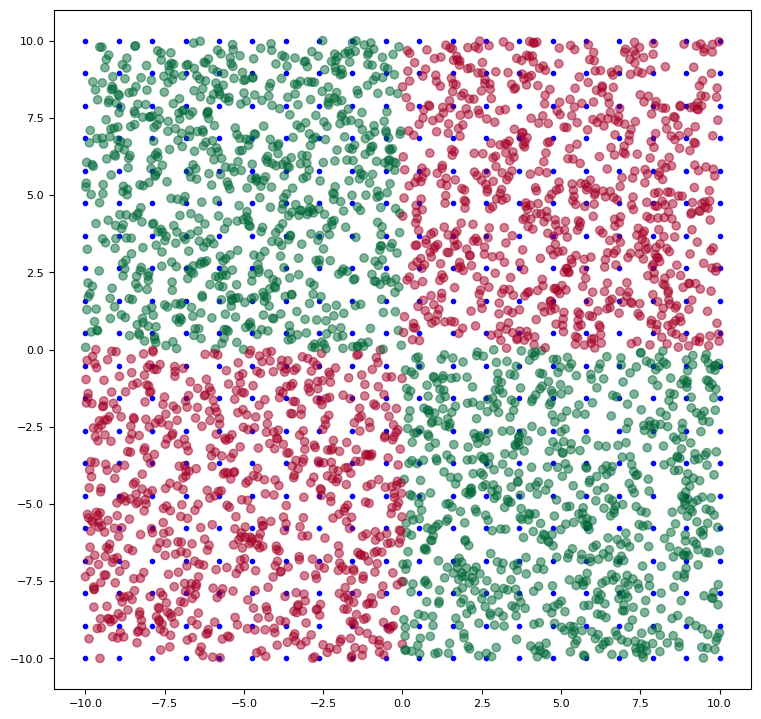

In [275]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
import datetime

EXEC_CODE = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# make dumy dataset
# x = sin(cos(2*pi*x) + noise)
# f = lambda x : tf.math.sin(tf.math.cos(2 * np.pi * x) + tf.random.normal(x.shape, stddev=0.1)) 

# x = sin(x)
# f = lambda x : tf.math.sin(x) 

# x, y = (x - y) / (x + y)
f = lambda x1, x2 : (x1 - x2) ** 2 - (x1 + x2) ** 2

nbp = 3000
x1 = tf.random.shuffle(tf.linspace(-10.0, 10.0, nbp))
x2 = tf.random.shuffle(tf.linspace(10.0, -10.0, nbp))
data = tf.data.Dataset.range(nbp).map(lambda _x: [x1[_x], x2[_x]])
data = data.map(lambda x1, x2: ([x1, x2], f(x1, x2)))
print(data.cardinality().numpy())

# print 10 first data
# for (x1, x2), y in data.take(10):
# 	print((x1.numpy(), x2.numpy()), y.numpy())
 
# plot
vect = np.array([[x1.numpy(), x2.numpy(), y.numpy()] for (x1, x2), y in data.take(nbp)])
fig, ax = plt.subplots(1, figsize=(9, 9), dpi=100)
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(min(vect[:, 2]), max(vect[:, 2])), cmap="RdYlGn"), ax=ax, fraction=0.046, pad=0.04)
ax.scatter(vect[:, 0], vect[:, 1], c=vect[:, 2], cmap='RdYlGn', vmax=max(vect[:, 2]), vmin=min(vect[:, 2]))
plt.show()

data = data.map(lambda x, y: (x, tf.cast(y > 0, tf.float16)))

vect = np.array([[x1.numpy(), x2.numpy(), y.numpy()] for [x1, x2], y in data.take(nbp)])
fig, ax = plt.subplots(1, figsize=(9, 9), dpi=100)
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(min(vect[:, 2]), max(vect[:, 2])), cmap="RdYlGn"), ax=ax, fraction=0.046, pad=0.04)
ax.scatter(vect[:, 0], vect[:, 1], c=vect[:, 2], cmap='RdYlGn', vmax=max(vect[:, 2]), vmin=min(vect[:, 2]))
plt.show()

data = data.map(lambda x, y: (x, tf.cast(y > 0, tf.float16)))
# for (x1, x2), y in data.take(10):
# 	print((x1.numpy(), x2.numpy()), y.numpy())

# linspace x, y
nbp = 20
xx, yy = np.meshgrid(np.linspace(-10,10, nbp),np.linspace(-10, 10, nbp))
X_boundary = np.c_[xx.ravel(), yy.ravel()]
print(xx.shape, yy.shape)
# plot the space
fig, ax = plt.subplots(1, figsize=(9, 9), dpi=100)
ax.scatter(xx, yy, c='b', marker='.')
ax.scatter(vect[:, 0], vect[:, 1], c=vect[:, 2], cmap='RdYlGn', vmax=max(vect[:, 2]), vmin=min(vect[:, 2]), alpha=0.5)
plt.show()

In [417]:
import tensorflow_addons as tfa

# make model
seed = 42
init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=seed)
dprate = 0.0
inputx = tf.keras.Input(shape=(2, ), name='inputx')
x = Dense(16, use_bias=True, name="hidden_1", kernel_initializer=init)(inputx)
x = Dropout(dprate)(Activation('tanh')(LayerNormalization()(x)))
x = Dense(8, use_bias=True, name="hidden_2", kernel_initializer=init)(x)
x = Dropout(dprate)(Activation('tanh')(LayerNormalization()(x)))
x2D = Dense(2, activation='tanh', use_bias=False, name='2D', kernel_initializer=init)(x)
output = Dense(1, activation='sigmoid', use_bias=True, name="pred", kernel_initializer=init)(x2D)
model = tf.keras.Model(inputs=inputx, outputs=output)
projectionModel = tf.keras.Model(inputs=inputx, outputs=x2D)

# compile model
LR = 0.0001
# LR = 0.1
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR) # tf.keras.optimizers.SGD(learning_rate=LR)
LRSHEDULE = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001)
model.compile(optimizer=OPTIMIZER, loss="binary_crossentropy", metrics="accuracy")

# train model
EPOCH = 100
BATCH_SIZE = 64

tqdmCallback = tfa.callbacks.TQDMProgressBar(leave_epoch_progress = False, leave_overall_progress = True, show_epoch_progress = False, show_overall_progress = True)

class GrabWeightsCallback(tf.keras.callbacks.Callback):
	def __init__(self, data, modelProj, modelPred, X_boundary):
		super().__init__()
		# for layer in model.layers: print(layer.name)
		self.data = data
		self.X_boundary = X_boundary
		# self.Ws = { layer.name: [] for layer in model.layers[1:] }
		self.W = []
		self.projectionModel = modelProj
		self.predModelPred = modelPred
		self.projection = []
		self.prediction = []
		self.truelabel = []
		self.decisionBoundary = []
	def on_epoch_end(self, epoch, logs=None):
		# for layer in self.model.layers[1:]:
		# 	self.Ws[layer.name].append(layer.get_weights()[0])
		self.W.append(self.model.layers[-1].get_weights())
		self.projection.append(self.projectionModel.predict(self.data))
		self.prediction.append(self.predModelPred.predict(self.data))
		self.truelabel.append([y for x, y in self.data])
		self.decisionBoundary.append(self.predModelPred.predict(self.X_boundary))
	def get(self):
		return self.projection, self.prediction, self.W, self.truelabel, self.decisionBoundary

# split data to train and test
data = data.shuffle(1000, seed=seed)
# split data to train and test with same ratio of positive and negative
data_pos = data.filter(lambda x, y: y > 0.5)
data_neg = data.filter(lambda x, y: y < 0.5)
pos_card, neg_card = len(list(data_pos.as_numpy_iterator())), len(list(data_neg.as_numpy_iterator()))
# print(pos_card, neg_card, data.cardinality())
data_train = data_pos.take(int(pos_card * 0.8)).concatenate(data_neg.take(int(neg_card * 0.8)))
data_test = data_pos.skip(int(pos_card * 0.8)).concatenate(data_neg.skip(int(neg_card * 0.8)))

GrabWeights = GrabWeightsCallback(data_test.batch(len(list(data_test.as_numpy_iterator()))).prefetch(tf.data.experimental.AUTOTUNE).cache(), projectionModel, model, X_boundary)

data_train = data_train.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).cache()
data_test  = data_test.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).cache()

hist = model.fit(data_train, validation_data=data_test, epochs=EPOCH, verbose=1, callbacks=[GrabWeights, LRSHEDULE])

histProjection, histPrediction, W, histtruelabel, decisionBoundary = GrabWeights.get()
histProjection, histPrediction, W, histtruelabel, decisionBoundary = np.array(histProjection), np.array(histPrediction), np.array(W), np.array(histtruelabel), np.array(decisionBoundary)



Epoch 1/100
38/38 [==============================] - 1s 24ms/step - loss: 0.6967 - accuracy: 0.5010 - val_loss: 0.6973 - val_accuracy: 0.5008 - lr: 1.0000e-04
Epoch 2/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.5056 - val_loss: 0.6967 - val_accuracy: 0.5042 - lr: 1.0000e-04
Epoch 3/100
38/38 [==============================] - 0s 6ms/step - loss: 0.6953 - accuracy: 0.5090 - val_loss: 0.6961 - val_accuracy: 0.5058 - lr: 1.0000e-04
Epoch 4/100
38/38 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.5140 - val_loss: 0.6956 - val_accuracy: 0.5075 - lr: 1.0000e-04
Epoch 5/100
38/38 [==============================] - 0s 7ms/step - loss: 0.6941 - accuracy: 0.5198 - val_loss: 0.6950 - val_accuracy: 0.5125 - lr: 1.0000e-04
Epoch 6/100
38/38 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5227 - val_loss: 0.6945 - val_accuracy: 0.5125 - lr: 1.0000e-04
Epoch 7/100
38/38 [==============================] 

C:\Users\Dylan\AppData\Local\Temp/ipykernel_7484/3371855409.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  histProjection, histPrediction, W, histtruelabel, decisionBoundary = np.array(histProjection), np.array(histPrediction), np.array(W), np.array(histtruelabel), np.array(decisionBoundary)


In [277]:
# save hist
import os
import json

class NumpyFloatValuesEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

folder = f"HIST_{EXEC_CODE}"
if not os.path.exists(folder):
	os.makedirs(folder)
 
np.save(folder + "/histProjection.npy", histProjection)
np.save(folder + "/histtruelabel.npy", histtruelabel)
np.save(folder + "/histPrediction.npy", histPrediction)
np.save(folder + "/W.npy", W)
np.save(folder + "/hist.npy", hist.history, allow_pickle=True)
# create json file with all parameters
config = {
    "EXEC_CODE": EXEC_CODE,
	"EPOCH": EPOCH,
	"BATCH_SIZE": BATCH_SIZE,
	"LR": LR,
	"OPTIMIZER": OPTIMIZER.get_config()
}
with open(folder + "/config.json", "w") as f:
	json.dump(config, f, cls=NumpyFloatValuesEncoder)



In [278]:
# folder = "HIST_20221018_120451"
# reload
histPrediction = np.load(folder + "/histPrediction.npy")
histtruelabel = np.load(folder + "/histtruelabel.npy")
W = np.load(folder + "/W.npy", allow_pickle=True)
hist = np.load(folder + "/hist.npy", allow_pickle=True).item()

In [279]:
metrics = [m for m in hist if not m.startswith("val_")]
fig, axes = plt.subplots(1, len(metrics), figsize=(8 *len(metrics), 9), dpi=200 * len(metrics))
i = 0
for key in metrics:
	axes[i].plot(hist[key], label=key)
	axes[i].set_title(key)
	axes[i].legend()
	valkey = "val_" + key
	if(valkey in hist):
		axes[i].set_title(key)
		axes[i].plot(hist[valkey], label=valkey)
		axes[i].legend()
	i += 1
plt.show()

In [280]:
print(histProjection.shape)
print(histPrediction.shape)
print(W.shape)
print(histtruelabel.shape)
print(decisionBoundary.shape)

(20, 601, 2)
(20, 601, 1)
(20, 2)
(20, 1, 601)
(20, 400, 1)


In [281]:
from matplotlib.colors import ListedColormap
from matplotlib import cm

viridis = cm.get_cmap('viridis', 256)
def make_cmap(start: tuple[int, int, int], end: tuple[int, int, int], N: int = 256):
	vals = np.ones((N, 4))
	vals[:, 0] = np.linspace(start[0] / 256, end[0]/256, N)
	vals[:, 1] = np.linspace(start[1] / 256, end[1]/256, N)
	vals[:, 2] = np.linspace(start[2] / 256, end[2]/256, N)
	return ListedColormap(vals)


0.5035431385040283 [256. 256. 256. 256.] [256. 127.  14. 256.]
0.5008319616317749 [256. 256. 256. 256.] [ 44. 160.  44. 256.]
20221019_152542.html


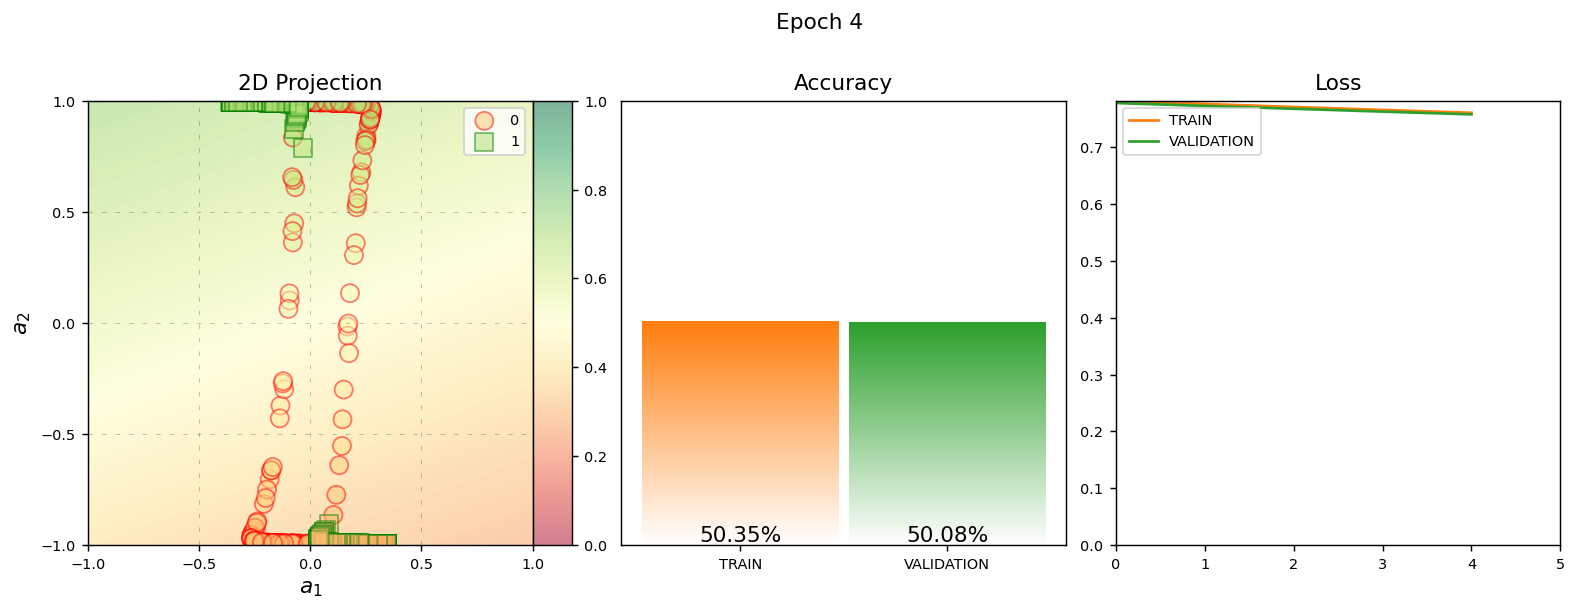

In [355]:
# # animation
# import matplotlib.animation as animation
# from IPython.display import HTML, clear_output
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # animate projection for each epoch

# def gradientbars(bars, cmaps):
# 	grad = np.atleast_2d(np.linspace(0,1,256)).T
# 	ax = bars[0].axes
# 	lim = ax.get_xlim()+ax.get_ylim()
# 	for bar, cmap in zip(bars, cmaps):
# 		bar.set_zorder(1)
# 		bar.set_facecolor("none")
# 		x,y = bar.get_xy()
# 		w, h = bar.get_width(), bar.get_height()
# 		start = np.array(cmap( (1 - h) * 256)) * 256
# 		end = np.array(cmap(0)) * 256
# 		print(h, start, end)
# 		c = make_cmap(end, start, 256)
# 		ax.imshow(grad, extent=[x,x+w,y,y+h], aspect="auto", zorder=0, cmap=c)
# 	ax.axis(lim)
 
# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 12

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# nbp = 50
# xx, yy = np.meshgrid(np.linspace(-1,1, nbp),np.linspace(-1, 1, nbp))
# X = np.c_[xx.ravel(), yy.ravel()]
# Model_Last_2Layers = tf.keras.models.Model(inputs=model.layers[-1].input, outputs=model.layers[-1].output)
# cmap = "RdYlGn"
# alphaBoundary = 0.5
# # init figure
# dpi = 130
# height = 650
# width = height * 3
# fig, axes = plt.subplots(1, 3, figsize=((width / dpi), (height / dpi)), dpi=dpi)

# # color bar 0 to 1
# # fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=cmap), ax=axes[0], fraction=0.046, pad=0.04)
# def update(i, init=False):
# 	# if i > 2: return
# 	print(i)
# 	clear_output(wait=True)
# 	axes[0].clear()
# 	# ensure axis is square
	
# 	Model_Last_2Layers.set_weights(W[i]) # set weights to epoch i
# 	Z = Model_Last_2Layers.predict(X) # predict on grid
# 	contourax0 = axes[0].contourf(xx, yy, Z.reshape(xx.shape), cmap=cmap, alpha=alphaBoundary, vmin=0, vmax=1, levels=100, antialiased=True)
# 	markers = ['o', 's']
# 	contourcolor = ['red', 'green']
# 	scatlegend = []
# 	for j in range(2):
# 		filtre = np.array(histtruelabel[i] == j).flatten()
# 		s = axes[0].scatter(histProjection[i, filtre, 0], histProjection[i, filtre, 1], marker=markers[j], c=histPrediction[i, filtre, 0], cmap=cmap, vmin=0, vmax=1, s=100, edgecolors=contourcolor[j], alpha=0.5)
# 		s.legend_elements(prop="colors", alpha=1)
# 		scatlegend.append(s)
#  	#legend
# 	axes[0].legend(handles=scatlegend, labels=['0', '1']) # loc='upper right')
#  	# axes[0].scatter(histProjection[i, :, 0], histProjection[i, :, 1], c=histPrediction[i, :, 0], cmap=cmap, vmin=0, vmax=1)
# 	axes[0].set_xlabel('$a_1$')
# 	axes[0].set_ylabel('$a_2$')
# 	axes[0].set_title(f'2D Projection', fontsize=BIGGER_SIZE)
# 	gap = 0.0
# 	axes[0].set_xlim(-1 - gap, 1 + gap) # plage du tanh (activation)
# 	axes[0].set_ylim(-1 - gap, 1 + gap)
# 	# nb ticks
# 	axes[0].set_xticks(np.linspace(-1, 1, 5))
# 	axes[0].set_yticks(np.linspace(-1, 1, 5))
# 	# ticks font size
# 	# grid light
# 	axes[0].grid(color="black", linestyle=(0, (5, 10)), linewidth=0.5, alpha=0.25)

# 	# plot bar accuracy
# 	axes[1].clear()
# 	bar = axes[1].bar(['TRAIN', 'VALIDATION'], [hist['accuracy'][i], hist['val_accuracy'][i]], color=['C1', 'C2'], width=0.95)
# 	gradientbars(bar, [make_cmap((256, 127, 14), (256, 256, 256), 256), make_cmap((44, 160, 44), (256, 256, 256), 256)])
# 	# text % on bar inner
# 	axes[1].text(0, 0, f"{hist['accuracy'][i]:.2%}", ha='center', va='bottom', color='black', fontsize=BIGGER_SIZE)
# 	axes[1].text(1, 0, f"{hist['val_accuracy'][i]:.2%}", ha='center', va='bottom', color='black', fontsize=BIGGER_SIZE)
# 	axes[1].set_ylim(0, 1)
# 	# remove y ticks
# 	axes[1].set_yticks([])
# 	# same height for both axes
# 	axes[1].set_title('Accuracy', fontsize=BIGGER_SIZE)
 
# 	# plot loss, val_loss
# 	axes[2].clear()
# 	loss = hist['loss'][0:i+1]
# 	val_loss = hist['val_loss'][0:i+1]
# 	axes[2].plot(loss, label='TRAIN', color='C1')
# 	axes[2].plot(val_loss, label='VALIDATION', color='C2')
# 	axes[2].set_ylim(0, max(max(loss), max(val_loss)))
# 	axes[2].set_xlim(0, len(loss))
# 	axes[2].set_title('Loss', fontsize=BIGGER_SIZE)
# 	axes[2].legend(loc='upper left')
	
# 	# axes[2].set_aspect(1.2 * len(loss), adjustable='box', anchor='C')
	
# 	# title for both axes
# 	fig.suptitle(f'Epoch {i}')
# 	# reduce white space between subplots
	
# 	space = 0.2
# 	fig.subplots_adjust(wspace=space, hspace=0)
# 	for ax in axes:
# 		# ax.set_aspect('equal', adjustable='box', anchor='C')
# 		ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
	
#  	# small left shift
# 	box = axes[2].get_position()
# 	axes[2].set_position([box.x0 - 0.02, box.y0, box.width, box.height])
	
# 	if(i == 0):
# 		cax = fig.add_axes([axes[0].get_position().x1+0.0, axes[0].get_position().y0, 0.02, axes[0].get_position().height])
# 		cax.set_yticks(np.linspace(0, 1, 4))
# 		color_bar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=cmap), cax=cax)
# 		color_bar.set_alpha(alphaBoundary)
# 		color_bar.draw_all()
# 		# big ax under the 3 first
	
# ani = animation.FuncAnimation(fig, update, frames=len(hist['loss']) - 15, init_func=lambda: None)

# # save animation
# import matplotlib
# # set animation.embed_limit to 100MB max for github upload
# matplotlib.rcParams['animation.embed_limit'] = 100 * 1024 * 1024
 
# with open(f"{EXEC_CODE}.html", "w") as f:
# 	print(ani.to_jshtml(), file=f)
# 	print(f"{EXEC_CODE}.html")


20221019_152542.html


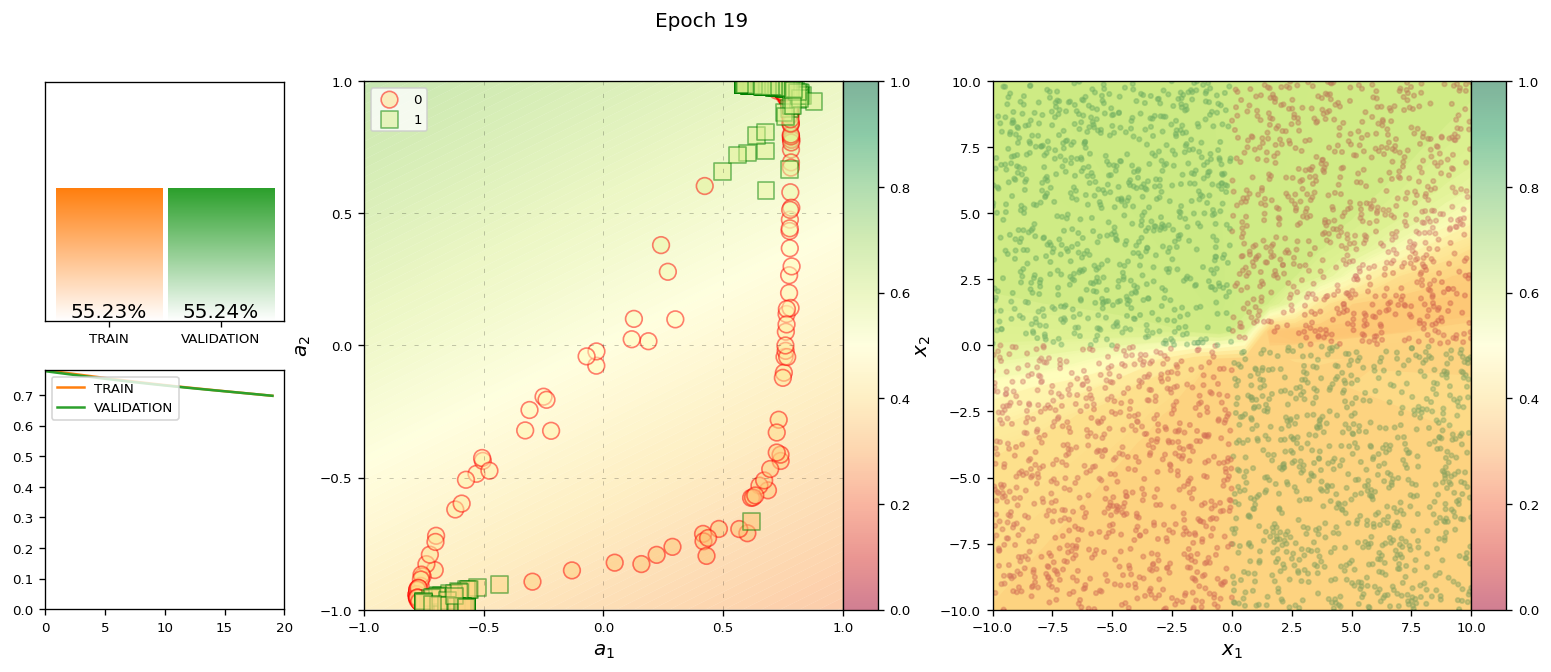

In [416]:
# animation
import matplotlib.animation as animation
from IPython.display import HTML, clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
# animate projection for each epoch

def gradientbars(bars, cmaps):
	grad = np.atleast_2d(np.linspace(0,1,256)).T
	ax = bars[0].axes
	lim = ax.get_xlim()+ax.get_ylim()
	for bar, cmap in zip(bars, cmaps):
		bar.set_zorder(1)
		bar.set_facecolor("none")
		x,y = bar.get_xy()
		w, h = bar.get_width(), bar.get_height()
		start = np.array(cmap( (1 - h) * 256)) * 256
		end = np.array(cmap(0)) * 256
		c = make_cmap(end, start, 256)
		ax.imshow(grad, extent=[x,x+w,y,y+h], aspect="auto", zorder=0, cmap=c)
	ax.axis(lim)
 
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
nbp = 50
xx, yy = np.meshgrid(np.linspace(-1, 1, nbp),np.linspace(-1, 1, nbp))
X = np.c_[xx.ravel(), yy.ravel()]
Model_Last_2Layers = tf.keras.models.Model(inputs=model.layers[-1].input, outputs=model.layers[-1].output)
cmap = "RdYlGn"
alphaBoundary = 0.5
# init figure
dpi = 120
base_size = 350
width = base_size * 5
height = base_size * 2
fig, axes = plt.subplots(2, 3, figsize=((width / dpi), (height / dpi)), dpi=dpi, gridspec_kw={'width_ratios': [1, 2, 2]})
gs = axes[1, 0].get_gridspec()
# fusionne 2 dernieres lignes
for ax in axes[:, -2:-1]:
	for a in ax:
		a.remove()
axproj = fig.add_subplot(gs[:, -2:-1])
axproj.annotate('Epoch 1', xy=(0.5, 0.5), xytext=(0, 0), textcoords='offset points', ha='center', va='center', fontsize=BIGGER_SIZE)
for ax in axes[:, -1]:
	ax.remove()
axboundary = fig.add_subplot(gs[:, -1])
print(axes)
# color bar 0 to 1
# fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=cmap), ax=axes[0], fraction=0.046, pad=0.04)
def update(i, init=False):
	# if i > 2: return
	print(i)
	clear_output(wait=True)
	# axproj = axes[0, 1]
	# axboundary = axes[0, 2]
	axacc = axes[0, 0]
	axloss = axes[1, 0]
	axproj.clear()
	
	Model_Last_2Layers.set_weights(W[i]) # set weights to epoch i
	Z = Model_Last_2Layers.predict(X) # predict on grid
	contourax0 = axproj.contourf(xx, yy, Z.reshape(xx.shape), cmap=cmap, alpha=alphaBoundary, vmin=0, vmax=1, levels=100, antialiased=True)
	markers = ['o', 's']
	contourcolor = ['red', 'green']
	scatlegend = []
	for j in range(2):
		filtre = np.array(histtruelabel[i] == j).flatten()
		s = axproj.scatter(histProjection[i, filtre, 0], histProjection[i, filtre, 1], marker=markers[j], c=histPrediction[i, filtre, 0], cmap=cmap, vmin=0, vmax=1, s=100, edgecolors=contourcolor[j], alpha=0.5)
		s.legend_elements(prop="colors", alpha=1)
		scatlegend.append(s)
 	#legend
	axproj.legend(handles=scatlegend, labels=['0', '1']) # loc='upper right')
 	# axproj.scatter(histProjection[i, :, 0], histProjection[i, :, 1], c=histPrediction[i, :, 0], cmap=cmap, vmin=0, vmax=1)
	axproj.set_xlabel('$a_1$')
	axproj.set_ylabel('$a_2$')
	# axproj.set_title(f'2D Projection', fontsize=BIGGER_SIZE)
	gap = 0.0
	axproj.set_xlim(-1 - gap, 1 + gap) # plage du tanh (activation)
	axproj.set_ylim(-1 - gap, 1 + gap)
	# nb ticks
	axproj.set_xticks(np.linspace(-1, 1, 5))
	axproj.set_yticks(np.linspace(-1, 1, 5))
	# ticks font size
	# grid light
	axproj.grid(color="black", linestyle=(0, (5, 10)), linewidth=0.5, alpha=0.25)

	# plot bar accuracy
	axacc.clear()
	bar = axacc.bar(['TRAIN', 'VALIDATION'], [hist['accuracy'][i], hist['val_accuracy'][i]], color=['C1', 'C2'], width=0.95)
	gradientbars(bar, [make_cmap((256, 127, 14), (256, 256, 256), 256), make_cmap((44, 160, 44), (256, 256, 256), 256)])
	# text % on bar inner
	axacc.text(0, 0, f"{hist['accuracy'][i]:.2%}", ha='center', va='bottom', color='black', fontsize=BIGGER_SIZE)
	axacc.text(1, 0, f"{hist['val_accuracy'][i]:.2%}", ha='center', va='bottom', color='black', fontsize=BIGGER_SIZE)
	axacc.set_ylim(0, 1)
	# remove y ticks
	axacc.set_yticks([])
	# same height for both axes
	# axacc.set_title('Accuracy', fontsize=BIGGER_SIZE)
 
	# plot loss, val_loss
	axloss.clear()
	loss = hist['loss'][0:i+1]
	val_loss = hist['val_loss'][0:i+1]
	axloss.plot(loss, label='TRAIN', color='C1')
	axloss.plot(val_loss, label='VALIDATION', color='C2')
	axloss.set_ylim(0, max(max(loss), max(val_loss)))
	axloss.set_xlim(0, len(loss))
	# axloss.set_title('Loss', fontsize=BIGGER_SIZE)
	axloss.legend(loc='upper left')
	
	# axloss.set_aspect(1.2 * len(loss), adjustable='box', anchor='C')
	
	# title for both axes
	fig.suptitle(f'Epoch {i}')
	# reduce white space between subplots
	
	space = 0.2
	fig.subplots_adjust(wspace=space, hspace=space)
	for lines in axes:
		for ax in lines:
			# ax.set_aspect('equal', adjustable='box', anchor='C')
			ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
	
 	# small right shift
	box = axboundary.get_position()
	axboundary.set_position([box.x0 + 0.04, box.y0, box.width, box.height])
	axboundary.set_xlabel('$x_1$')
	axboundary.set_ylabel('$x_2$')
	
	# axboundary.set_title(f'2D Input')
	axboundary.scatter(vect[:, 0], vect[:, 1], c=vect[:, 2], cmap='RdYlGn', vmax=1, vmin=0, s=7, alpha=0.25)
	# boundary decision
	nbp = 20
	axboundary.contourf(X_boundary[:, 0].reshape(nbp, nbp), X_boundary[:, 1].reshape(nbp, nbp), decisionBoundary[i].reshape(nbp, nbp), cmap=cmap, alpha=0.5, vmin=0, vmax=1, levels=10, antialiased=True)        
	
	if(i == 0):
		cax = fig.add_axes([axboundary.get_position().x1+0.0, axboundary.get_position().y0, 0.02, axboundary.get_position().height])
		cax.set_yticks(np.linspace(0, 1, 4))
		color_bar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=cmap), cax=cax)
		color_bar.set_alpha(alphaBoundary)
		color_bar.draw_all()

		cax = fig.add_axes([axproj.get_position().x1+0.0, axproj.get_position().y0, 0.02, axproj.get_position().height])
		cax.set_yticks(np.linspace(0, 1, 4))
		color_bar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=cmap), cax=cax)
		color_bar.set_alpha(alphaBoundary)
		color_bar.draw_all()
		# big ax under the 3 first
	
ani = animation.FuncAnimation(fig, update, frames=len(hist['loss']), init_func=lambda: None)

# save animation
import matplotlib
# set animation.embed_limit to 100MB max for github upload
matplotlib.rcParams['animation.embed_limit'] = 100 * 1024 * 1024
with open(f"{EXEC_CODE}.html", "w") as f:
	print(ani.to_jshtml(), file=f)
	print(f"{EXEC_CODE}.html")
